In [1]:
# Libraries

import pandas as pd
import time
import numpy as np
import random
import os
from tqdm import tqdm
import itertools
import PIL

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img
import keras_tuner as kt
from tensorflow import keras

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

## Preprocessing

In [2]:
# Emplacement
path = 'D:/documents/GitHub/Radios_COVID19/COVID-19_Radiography_Dataset'

dirs = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]
dirsm = ["Normal/masks/","COVID/masks/","Lung_Opacity/masks/","Viral Pneumonia/masks/"]

id_dir = 5

# Classes de 0 à 3 dans la suite
classes = ("Normal","COVID ","Lung_Opacity","Viral Pneumonia") 
nbClasses = len(classes)

In [3]:
# Création des 4 listes de noms d'images

normal_imgs = [fn for fn in os.listdir(f'{path}/Normal/masked_images') if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(f'{path}/COVID/masked_images') if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(f'{path}/Viral Pneumonia/masked_images') if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(f'{path}/Lung_Opacity/masked_images') if fn.endswith('.png')]

In [4]:
# Concaténation des emplacements de toutes les images dans une liste unique
liste_paths = []

for fn in normal_imgs :
    liste_paths.append(f'{path}/Normal/masked_images/' + fn)
for fn in covid_imgs :
    liste_paths.append(f'{path}/COVID/masked_images/' + fn)
for fn in pneumonia_imgs :
    liste_paths.append(f'{path}/Viral Pneumonia/masked_images/' + fn)
for fn in lung_opacity_imgs :
    liste_paths.append(f'{path}/Lung_Opacity/masked_images/' + fn)

# Découpage des noms de chaque emplacement et récupération de la classe (liste de listes)
liste_paths_classes = list(map(lambda x : [x, x.split('/')[id_dir]], liste_paths)) 

In [5]:
# Création Dataframe des emplacements et classes images BRUTES
df = pd.DataFrame(liste_paths_classes, columns = ['filepath', 'nameLabel'])

# Remplacement des classes sous forme littérale par index
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df['label'] = df['label'].astype(str)

# Mélange du dataframe
df = df.sample(frac = 1, random_state = 42)
df = df.reset_index(drop=True)

# Nettoyage variables inutiles
del liste_paths

ech_size = 2000

df = df[0:ech_size]
df.head()

,filepath,nameLabel,label
0,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Lung_Opacity,3
1,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
2,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Viral Pneumonia,2
3,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,COVID,1
4,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Viral Pneumonia,2


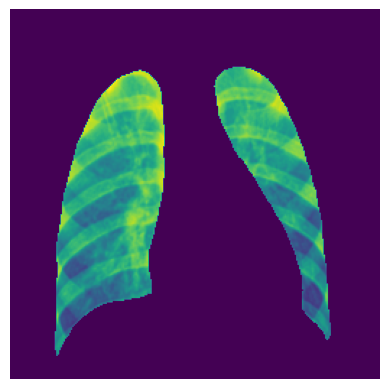

In [6]:
#Charger Exemple Image
filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

In [7]:
size = (240, 240)
ratio_val = 0.2 
batch_generator = 32

# Séparation dataframe en ensemble entraiement et validation
train_total, test = train_test_split(df, test_size = ratio_val, shuffle = False)
train, valid = train_test_split(train_total, test_size = 0.1)

# Création des itérateurs qui chargeront des lots d'images
datagen = ImageDataGenerator( )
test_datagen = ImageDataGenerator( )

print(f"Number of rows in TRAIN total set: {len(train_total)}")
print(f" - Number of rows in train_set: {len(train)}")
print(f" - Number of rows in valid_set: {len(valid)}")

train_generator = datagen.flow_from_dataframe(dataframe = train,
                                              x_col="filepath",
                                              y_col="label",
                                              class_mode = "sparse",
                                              target_size = size,
                                              batch_size = batch_generator)

valid_generator = datagen.flow_from_dataframe(dataframe = valid,
                                              x_col="filepath",
                                              y_col="label",
                                              class_mode = "sparse",
                                              target_size = size,
                                              batch_size = batch_generator)

Number of rows in TRAIN total set: 1600
 - Number of rows in train_set: 1440
 - Number of rows in valid_set: 160
Found 1440 validated image filenames belonging to 4 classes.
Found 160 validated image filenames belonging to 4 classes.


In [8]:
print(f"Number of rows in TEST set: {len(test)}")

test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                x_col="filepath",
                                                y_col="label",
                                                class_mode = "sparse",
                                                target_size = size,
                                                batch_size = batch_generator,
                                                shuffle = False) 

X_test = []

for filepath in tqdm(test['filepath']) :
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels = 1)
    im = tf.image.resize (im, size)
    X_test.append([im])
    
X_test = tf.concat(X_test, axis = 0)

Number of rows in TEST set: 400
Found 400 validated image filenames belonging to 4 classes.


100%|██████████| 400/400 [00:00<00:00, 498.09it/s]


## EfficientNetB1 Model

In [19]:
# Chargement du modèle efficientNet
efficientNet_base = EfficientNetB1(weights = 'imagenet', include_top = False)

# Bloquage du blackbone
for layer in efficientNet_base.layers:
    layer.trainable = False
    
efficientNet_base.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_2 (Normalization  (None, None, None,   7          ['rescaling_4[0][0]']            
 )                              3)                                                   

                                                                                                  
 block1b_add (Add)              (None, None, None,   0           ['block1b_drop[0][0]',           
                                16)                               'block1a_project_bn[0][0]']     
                                                                                                  
 block2a_expand_conv (Conv2D)   (None, None, None,   1536        ['block1b_add[0][0]']            
                                96)                                                               
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, None, None,   384        ['block2a_expand_conv[0][0]']    
 ization)                       96)                                                               
                                                                                                  
 block2a_e

                                24)                               'block2a_project_bn[0][0]']     
                                                                                                  
 block2c_expand_conv (Conv2D)   (None, None, None,   3456        ['block2b_add[0][0]']            
                                144)                                                              
                                                                                                  
 block2c_expand_bn (BatchNormal  (None, None, None,   576        ['block2c_expand_conv[0][0]']    
 ization)                       144)                                                              
                                                                                                  
 block2c_expand_activation (Act  (None, None, None,   0          ['block2c_expand_bn[0][0]']      
 ivation)                       144)                                                              
          

 block3b_expand_conv (Conv2D)   (None, None, None,   9600        ['block3a_project_bn[0][0]']     
                                240)                                                              
                                                                                                  
 block3b_expand_bn (BatchNormal  (None, None, None,   960        ['block3b_expand_conv[0][0]']    
 ization)                       240)                                                              
                                                                                                  
 block3b_expand_activation (Act  (None, None, None,   0          ['block3b_expand_bn[0][0]']      
 ivation)                       240)                                                              
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, None, None,   6000       ['block3b_expand_activation[0][0]
 D)       

                                                                                                  
 block4a_expand_conv (Conv2D)   (None, None, None,   9600        ['block3c_add[0][0]']            
                                240)                                                              
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, None, None,   960        ['block4a_expand_conv[0][0]']    
 ization)                       240)                                                              
                                                                                                  
 block4a_expand_activation (Act  (None, None, None,   0          ['block4a_expand_bn[0][0]']      
 ivation)                       240)                                                              
                                                                                                  
 block4a_d

                                480)                                                              
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, None, None,   1920       ['block4c_expand_conv[0][0]']    
 ization)                       480)                                                              
                                                                                                  
 block4c_expand_activation (Act  (None, None, None,   0          ['block4c_expand_bn[0][0]']      
 ivation)                       480)                                                              
                                                                                                  
 block4c_dwconv (DepthwiseConv2  (None, None, None,   4320       ['block4c_expand_activation[0][0]
 D)                             480)                             ']                               
          

 block5a_expand_conv (Conv2D)   (None, None, None,   38400       ['block4d_add[0][0]']            
                                480)                                                              
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, None, None,   1920       ['block5a_expand_conv[0][0]']    
 ization)                       480)                                                              
                                                                                                  
 block5a_expand_activation (Act  (None, None, None,   0          ['block5a_expand_bn[0][0]']      
 ivation)                       480)                                                              
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, None, None,   12000      ['block5a_expand_activation[0][0]
 D)       

                                                                                                  
 block5c_expand_activation (Act  (None, None, None,   0          ['block5c_expand_bn[0][0]']      
 ivation)                       672)                                                              
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, None, None,   16800      ['block5c_expand_activation[0][0]
 D)                             672)                             ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, None, None,   2688       ['block5c_dwconv[0][0]']         
 )                              672)                                                              
                                                                                                  
 block5c_a

 ization)                       672)                                                              
                                                                                                  
 block6a_expand_activation (Act  (None, None, None,   0          ['block6a_expand_bn[0][0]']      
 ivation)                       672)                                                              
                                                                                                  
 block6a_dwconv_pad (ZeroPaddin  (None, None, None,   0          ['block6a_expand_activation[0][0]
 g2D)                           672)                             ']                               
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, None, None,   16800      ['block6a_dwconv_pad[0][0]']     
 D)                             672)                                                              
          

 block6c_expand_activation (Act  (None, None, None,   0          ['block6c_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6c_expand_activation[0][0]
 D)                             1152)                            ']                               
                                                                                                  
 block6c_bn (BatchNormalization  (None, None, None,   4608       ['block6c_dwconv[0][0]']         
 )                              1152)                                                             
                                                                                                  
 block6c_activation (Activation  (None, None, None,   0          ['block6c_bn[0][0]']             
 )        

                                                                                                  
 block6e_expand_activation (Act  (None, None, None,   0          ['block6e_expand_bn[0][0]']      
 ivation)                       1152)                                                             
                                                                                                  
 block6e_dwconv (DepthwiseConv2  (None, None, None,   28800      ['block6e_expand_activation[0][0]
 D)                             1152)                            ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, None, None,   4608       ['block6e_dwconv[0][0]']         
 )                              1152)                                                             
                                                                                                  
 block6e_a

 D)                             1920)                            ']                               
                                                                                                  
 block7b_bn (BatchNormalization  (None, None, None,   7680       ['block7b_dwconv[0][0]']         
 )                              1920)                                                             
                                                                                                  
 block7b_activation (Activation  (None, None, None,   0          ['block7b_bn[0][0]']             
 )                              1920)                                                             
                                                                                                  
 block7b_se_squeeze (GlobalAver  (None, 1920)        0           ['block7b_activation[0][0]']     
 agePooling2D)                                                                                    
          

In [20]:
def efficientnetb1() :
    model = Sequential()
    
    model.add(efficientNet_base)
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 1024, activation = 'relu'))
    model.add(Dropout(rate = 0.2))
    model.add(Dense(units = 512, activation = 'relu'))
    model.add(Dropout(rate = 0.2))
    model.add(Dense(units = 4, activation = 'softmax'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    #hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    hp_learning_rate = 0.001
    
    model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), 
                  metrics = ["accuracy"])
    
    return model

In [21]:
model = efficientnetb1()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                      

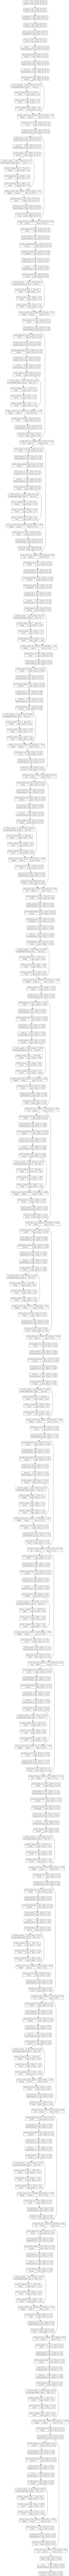

In [15]:
from keras.utils.vis_utils import plot_model

plot_model(efficientNet_base, to_file = 'efficientnetb1_base_plot.png', show_shapes = True, show_layer_names = True)

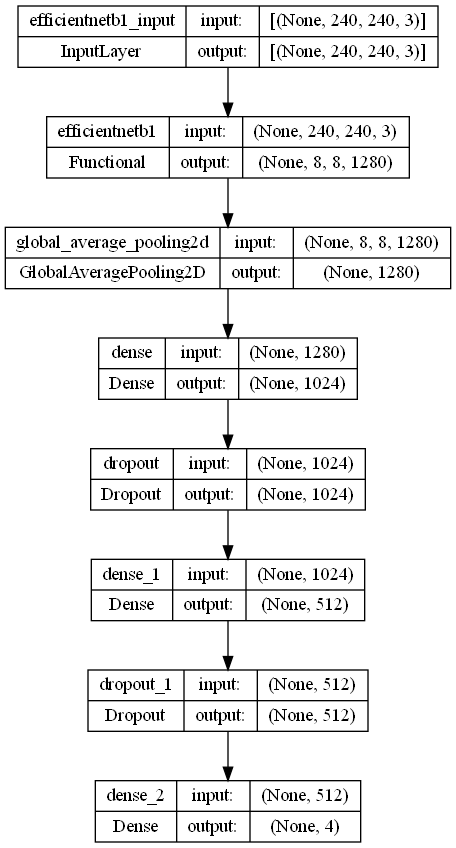

In [16]:
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

In [22]:
#Callbacks

#define checkpoint
checkpoint = ModelCheckpoint('model.h5', 
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'auto',
                             verbose = 1)

#early stopping
#EarlyStopping: a regularization technique, meaning that the model will stop training if it doesn’t see any improvement in 
#val_accuracy in patience = 5 i.e. 5 epochs.'
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 5,
                          mode = 'auto',
                          verbose = 1)

#reduce learning rate
#ReduceLROnPlateau to reduce learning rate when val_accuracy has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode = 'auto',
                              verbose = 1)

## Entrainement Modèle

In [ ]:
# Unable to use checkpoint callback with TF V2.10
#So I tried to downgrade tensorflow from V2.10 to V2.9.1, this function works fine. In other words, this is a bug in 2.10.0. Hope it helps and please fix this bug for V2.10

In [24]:
# Entrainement du modèle
train_size = train_generator.samples
valid_size = valid_generator.samples

batch_model = 32
epochs = 10

history = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_size // batch_model,
                    validation_data = valid_generator,
                    validation_steps = valid_size // batch_model,
                    verbose = 1,
                    callbacks = [earlystop, reduce_lr])

Epoch 1/10
45/45 [==============================] - 55s 1s/step - loss: 0.5981 - accuracy: 0.7458 - val_loss: 0.5309 - val_accuracy: 0.7688 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - 56s 1s/step - loss: 0.4611 - accuracy: 0.8153 - val_loss: 0.3986 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - 58s 1s/step - loss: 0.4661 - accuracy: 0.8056 - val_loss: 0.4382 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 4/10
45/45 [==============================] - 61s 1s/step - loss: 0.3877 - accuracy: 0.8438 - val_loss: 0.3895 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 5/10
45/45 [==============================] - 60s 1s/step - loss: 0.4353 - accuracy: 0.8194 - val_loss: 0.3941 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 6/10
45/45 [==============================] - ETA: 0s - loss: 0.4168 - accuracy: 0.8424
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
45/45 [==============================] - 56s 1s/step - loss: 0.41

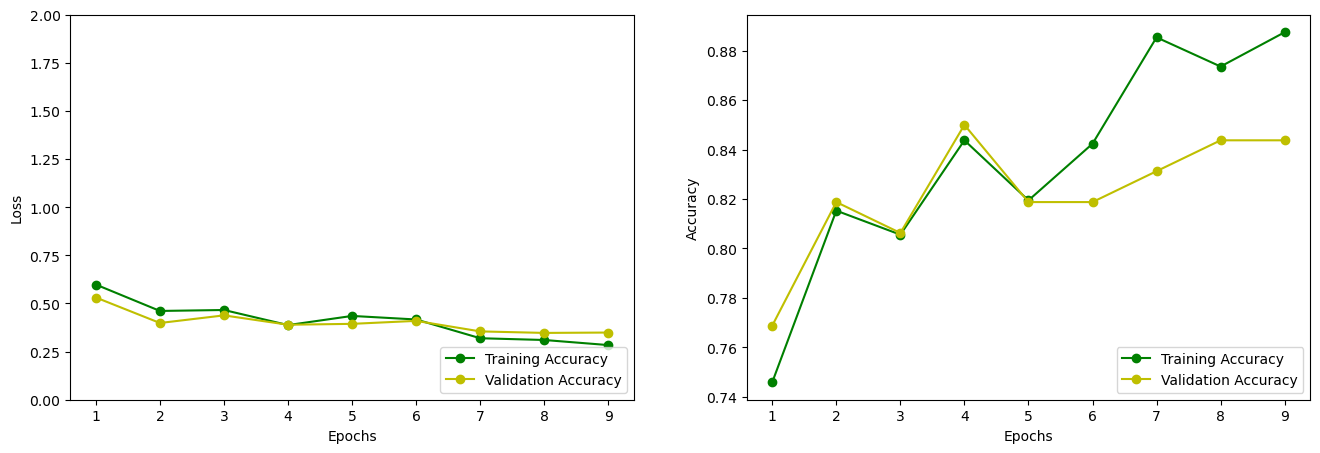

In [25]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.subplot(121)
plt.plot(epochs, train_loss, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

plt.subplot(122)
plt.plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

## Model Performance 

In [26]:
print('TRAIN accuracy & loss:', model.evaluate(train_generator))
print('\n')
print('TEST accuracy & loss:', model.evaluate(test_generator))

45/45 [==============================] - 56s 1s/step - loss: 0.2213 - accuracy: 0.9250
TRAIN accuracy & loss: [0.22125142812728882, 0.925000011920929]


13/13 [==============================] - 16s 1s/step - loss: 0.3932 - accuracy: 0.8450
TEST accuracy & loss: [0.39323845505714417, 0.8450000286102295]


#### Predictions 

In [27]:
y_test = test_generator.classes
y_test = pd.DataFrame(y_test).astype(int)

y_pred = np.argmax(model.predict(test_generator), axis = 1)

13/13 [==============================] - 17s 984ms/step


#### Confusion Matrix 

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

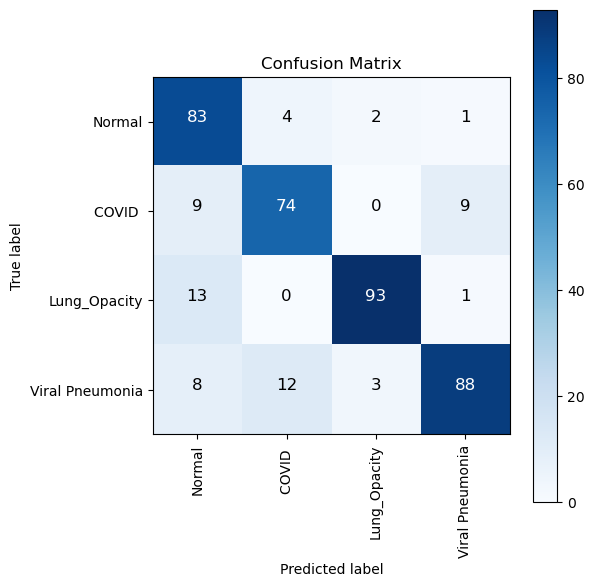

[[83  4  2  1]
 [ 9 74  0  9]
 [13  0 93  1]
 [ 8 12  3 88]]


In [29]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, classes, normalize = False)
print(cm)

#### Classification Report 

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.92      0.82        90
           1       0.82      0.80      0.81        92
           2       0.95      0.87      0.91       107
           3       0.89      0.79      0.84       111

    accuracy                           0.84       400
   macro avg       0.85      0.85      0.84       400
weighted avg       0.85      0.84      0.85       400



## Predictions on Test Images 

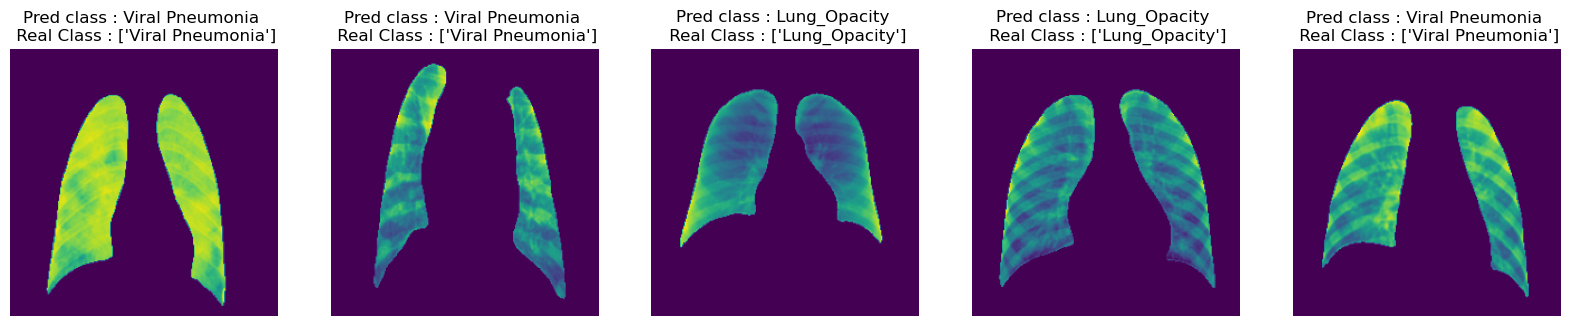

In [31]:
#Prédiction du modèle

indices_random = tf.random.uniform([5], 0, len(test['filepath']), dtype = tf.int32)

plt.figure(figsize = (20,7))

for i, idx in enumerate(indices_random) :
    plt.subplot(1,5,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.axis('off')
    plt.title('Pred class : {} \n Real Class : {}'.format(df.nameLabel.unique()[y_pred[idx]], df.nameLabel.unique()[y_test.values[idx]]))

In [32]:
model.save_weights("model_efficientB1_callbacks_2000mkd.h5")

In [ ]:
model.load_weights("C:/Users/utilisateur/COVID19 - Projet/model_efficientB1_callbacks_2000mkd.h5")